In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_MOUSE"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-GC-IGH_MOUSE-after-reassignment.csv']

In [3]:
pt_file="20201013-DataSheet-Maria-mouse.csv"
run = "runMaria-mouse"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: runMaria-mouse-similarity-IGH_MOUSE.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,MSmm-01_S1,nomatch,CARGGLYWYFDVWGTGTTLT,59,1,IGHV5-17,IGHJ1,1,0.016949,0.287510,0.009177
1,MSmm-01_S1,nomatch,CARRAVVATPYWYFDVWGTGTLLT,43,1,IGHV5-17,IGHJ1,0,0.000000,0.209541,0.009177
2,MSmm-01_S1,nomatch,CKTHDGYYSYWYFDVWGTGTLLT,40,1,IGHV5-2,IGHJ1,0,0.000000,0.194922,0.009177
3,MSmm-01_S1,nomatch,CARRAVVATPYWYFDVWGTGTPLT,38,1,IGHV5-17+IGHV5-4,IGHJ1,0,0.000000,0.185176,0.009177
4,MSmm-01_S1,nomatch,YWYFDVWGTGTLLT,37,1,IGHV5-17+IGHV5-4,IGHJ1,0,0.000000,0.180303,0.009177


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
54768,MSmm-05_S5,FDVWGTGTLLT,29,1,0,0.00,0.151697,0.008273
54778,MSmm-05_S5,FDVWGTGTTLT,29,1,0,0.00,0.151697,0.008273
54759,MSmm-05_S5,DYWGQGTTLT,25,1,1,0.04,0.130774,0.008273
54890,MSmm-05_S5,WGQGTTLT,25,1,0,0.00,0.130774,0.008273
53104,MSmm-05_S5,CKTEDDGYLYWYFDVWGTGTTLT,24,1,0,0.00,0.125543,0.008273


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI,filename
0,MSmm-01,MSmm-01,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201013-maria-mouse,S1,GC,mouse,BCRh,Unknown,MSmm-01,no,MSmm-01_S1_L001_R1_001.fastq.gz
1,MSmm-02,MSmm-02,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201013-maria-mouse,S2,GC,mouse,BCRh,Unknown,MSmm-02,no,MSmm-02_S2_L001_R1_001.fastq.gz
2,MSmm-03,MSmm-03,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201013-maria-mouse,S3,GC,mouse,BCRh,Unknown,MSmm-03,no,MSmm-03_S3_L001_R1_001.fastq.gz
3,MSmm-04,MSmm-04,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201013-maria-mouse,S4,GC,mouse,BCRh,Unknown,MSmm-04,no,MSmm-04_S4_L001_R1_001.fastq.gz
4,MSmm-05,MSmm-05,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201013-maria-mouse,S5,GC,mouse,BCRh,Unknown,MSmm-05,no,MSmm-05_S5_L001_R1_001.fastq.gz


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,MSmm-01_S1,Unknown
1,MSmm-02_S2,Unknown
2,MSmm-03_S3,Unknown
3,MSmm-04_S4,Unknown
4,MSmm-05_S5,Unknown


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,MSmm-05_S5,FDVWGTGTLLT,29,1,0,0.00,0.151697,0.008273,Unknown
1,MSmm-05_S5,FDVWGTGTTLT,29,1,0,0.00,0.151697,0.008273,Unknown
2,MSmm-05_S5,DYWGQGTTLT,25,1,1,0.04,0.130774,0.008273,Unknown
3,MSmm-05_S5,WGQGTTLT,25,1,0,0.00,0.130774,0.008273,Unknown
4,MSmm-05_S5,CKTEDDGYLYWYFDVWGTGTTLT,24,1,0,0.00,0.125543,0.008273,Unknown


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient         Unknown                                            
Sample       MSmm-01_S1 MSmm-02_S2 MSmm-03_S3 MSmm-04_S4 MSmm-05_S5
cdr3pep                                                            
AMDYWGQGTILT        1.0        0.0        0.0        1.0        0.0
AMDYWGQGTLLT        0.0        0.0        0.0        0.0        2.0
AMDYWGQGTLVT        1.0        0.0        0.0        0.0        1.0
AMDYWGQGTPLT        4.0        1.0        1.0        0.0        0.0
AMDYWGQGTPVT        5.0        0.0        0.0        0.0        1.0

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient               Unknown                                            
Sample             MSmm-01_S1 MSmm-02_S2 MSmm-03_S3 MSmm-04_S4 MSmm-05_S5
Patient Sample                                                           
Unknown MSmm-01_S1   1.000000   0.017249   0.018109   0.017854   0.021394
        MSmm-02_S2   0.017249   1.000000   0.017978   0.015351   0.022647
        MSmm-03_S3   0.018109   0.017978   1.000000   0.020960   0.020214
        MSmm-04_S4   0.017854   0.015351   0.020960   1.000000   0.022419
        MSmm-05_S5   0.021394   0.022647   0.020214   0.022419   1.000000

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote runMaria-mouse-similarity-IGH_MOUSE.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 0.015351128422499749
max value: 1.0
Wrote runMaria-mouse-similarity-IGH_MOUSE.pdf to disk


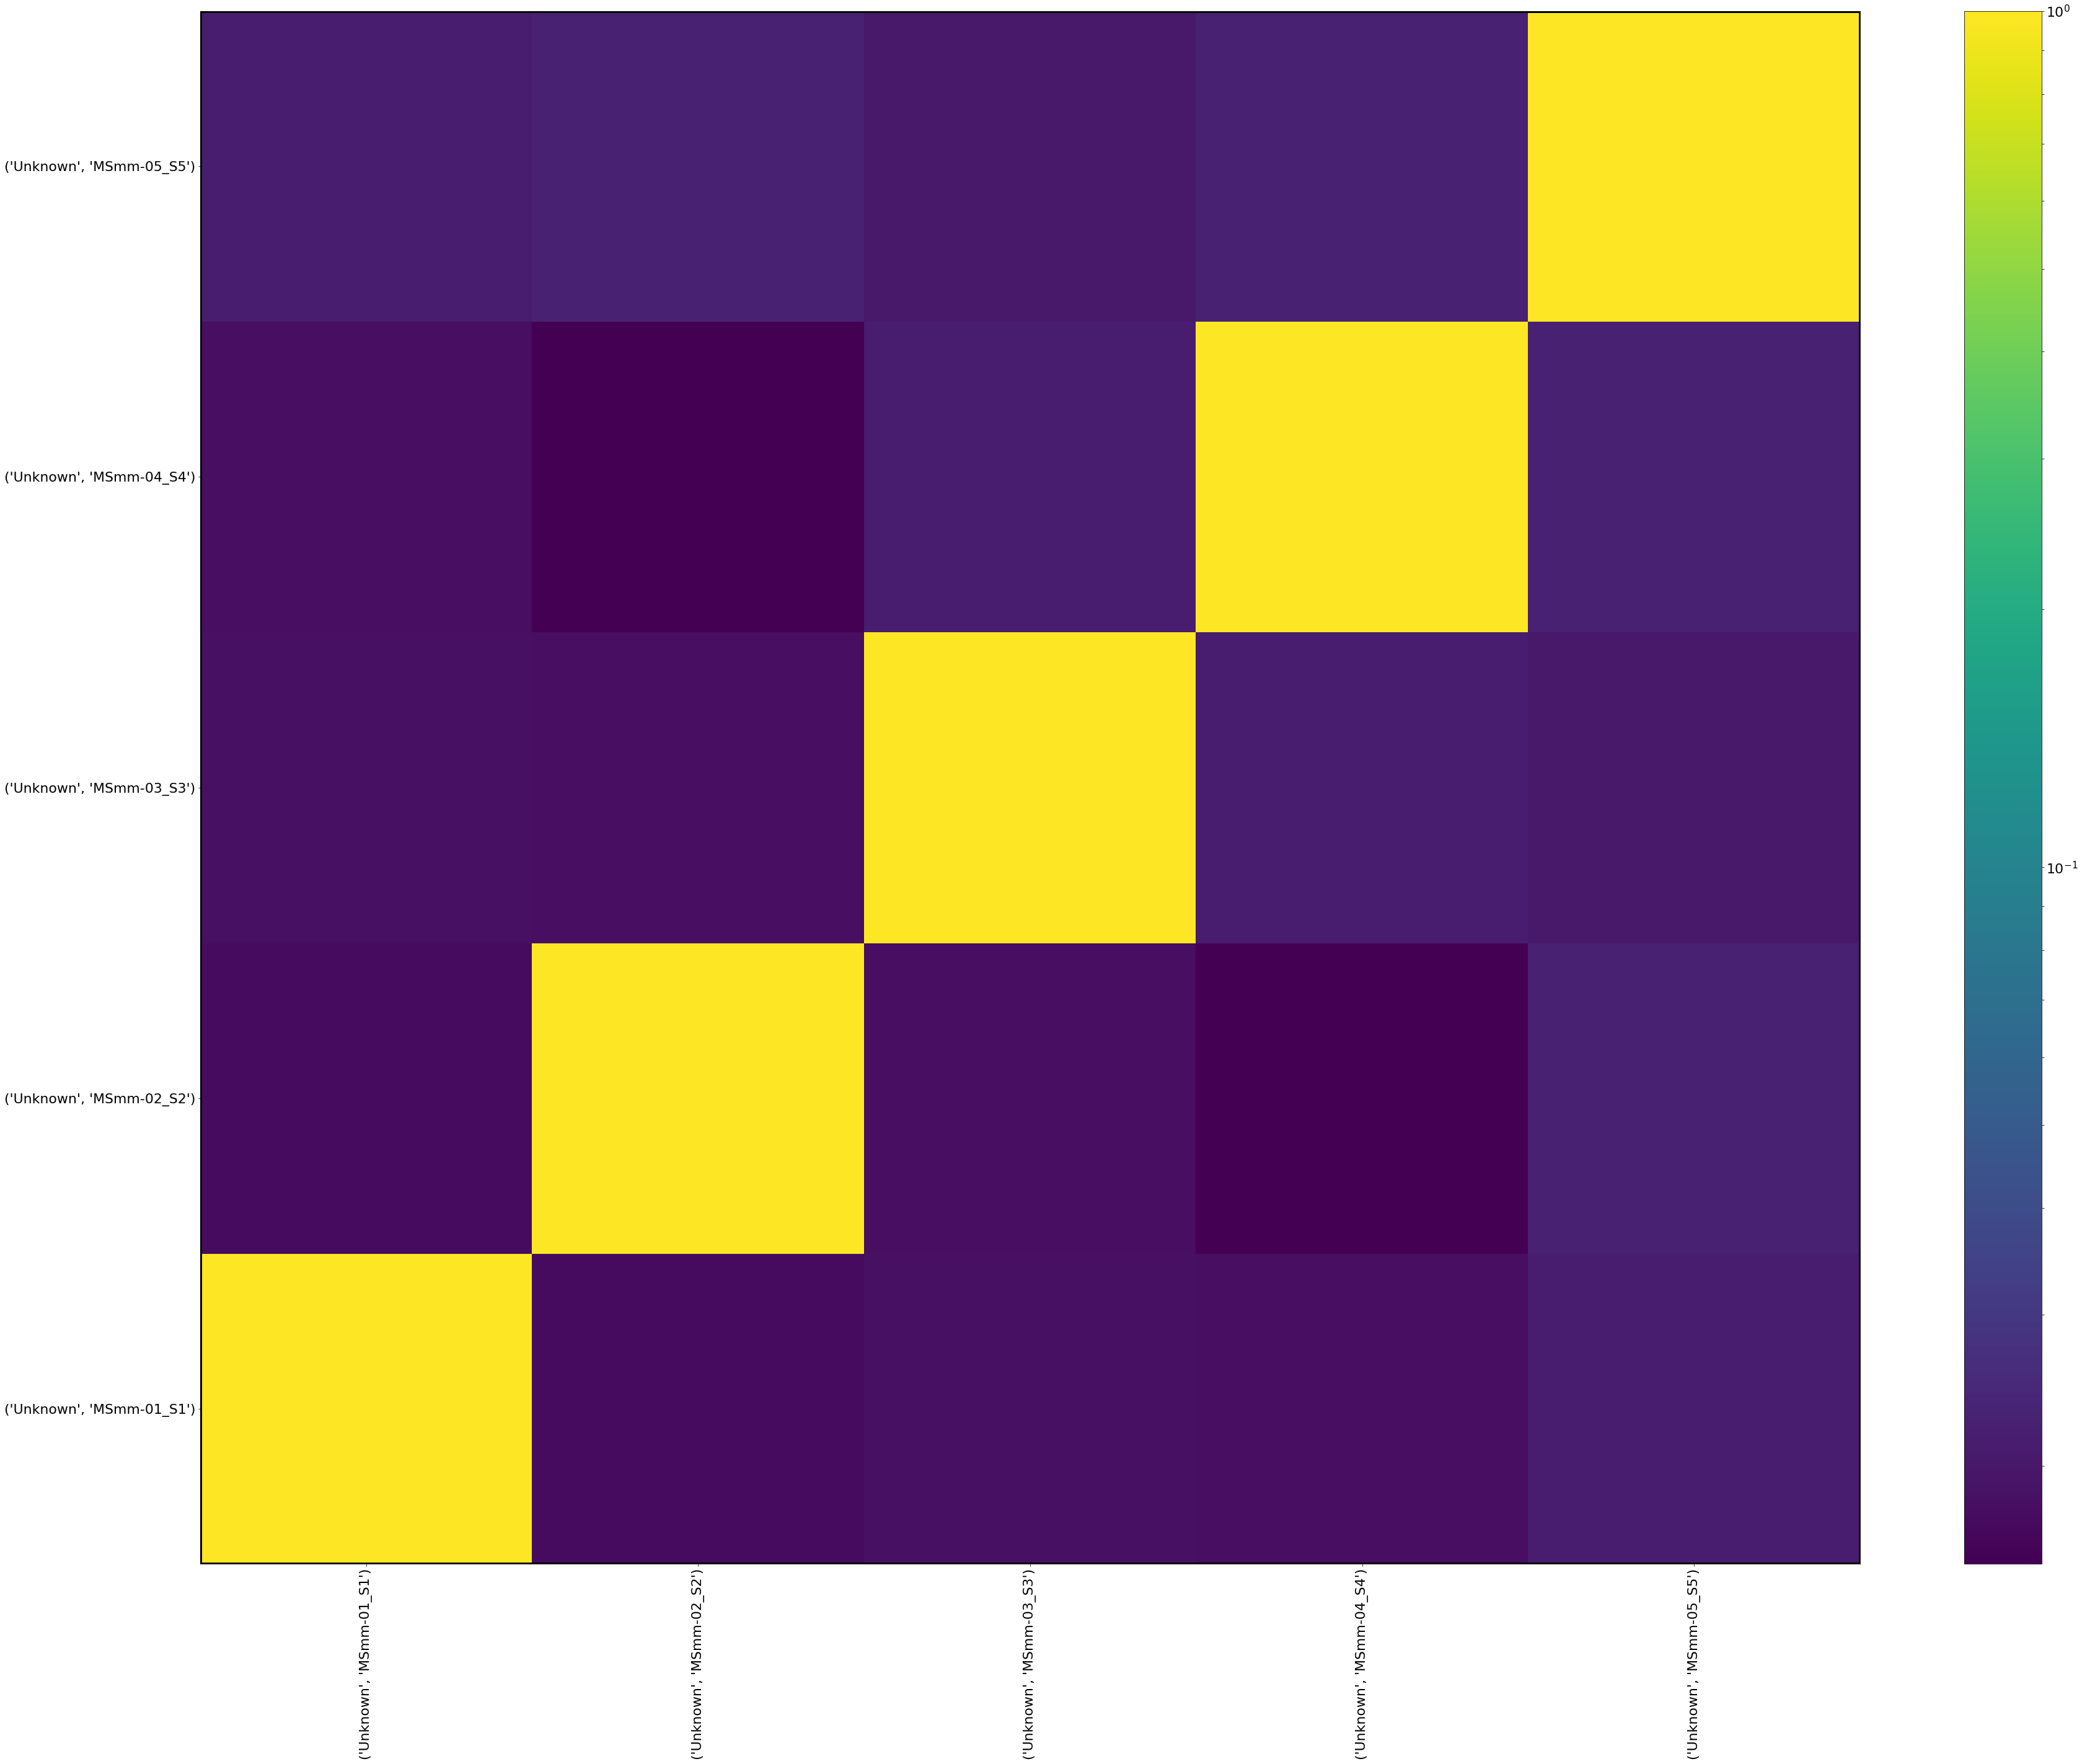

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.019417553864118708 0.0023200941633641156
mean diff patient nan nan
threshold nan


/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fd869af8358>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd869af8c18>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd869af8208>,
 'medians': [<matplotlib.lines.Line2D at 0x7fd869b034a8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd869b038d0>,
 'means': []}

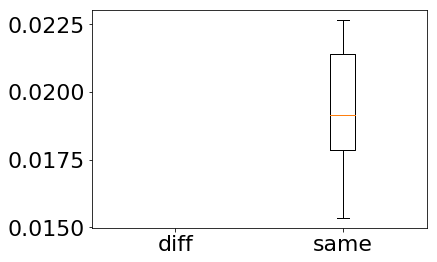

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

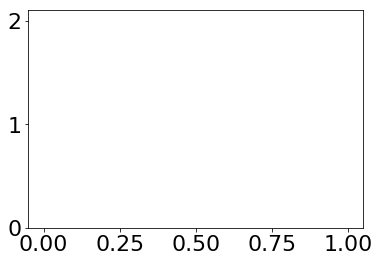

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

Wrote runMaria-mouse-similarity-IGH_MOUSE.txt to disk


In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 0.015351128422499749
max value: 1.0
Wrote runMaria-mouse-similarity-IGH_MOUSE-highlighted.pdf to disk


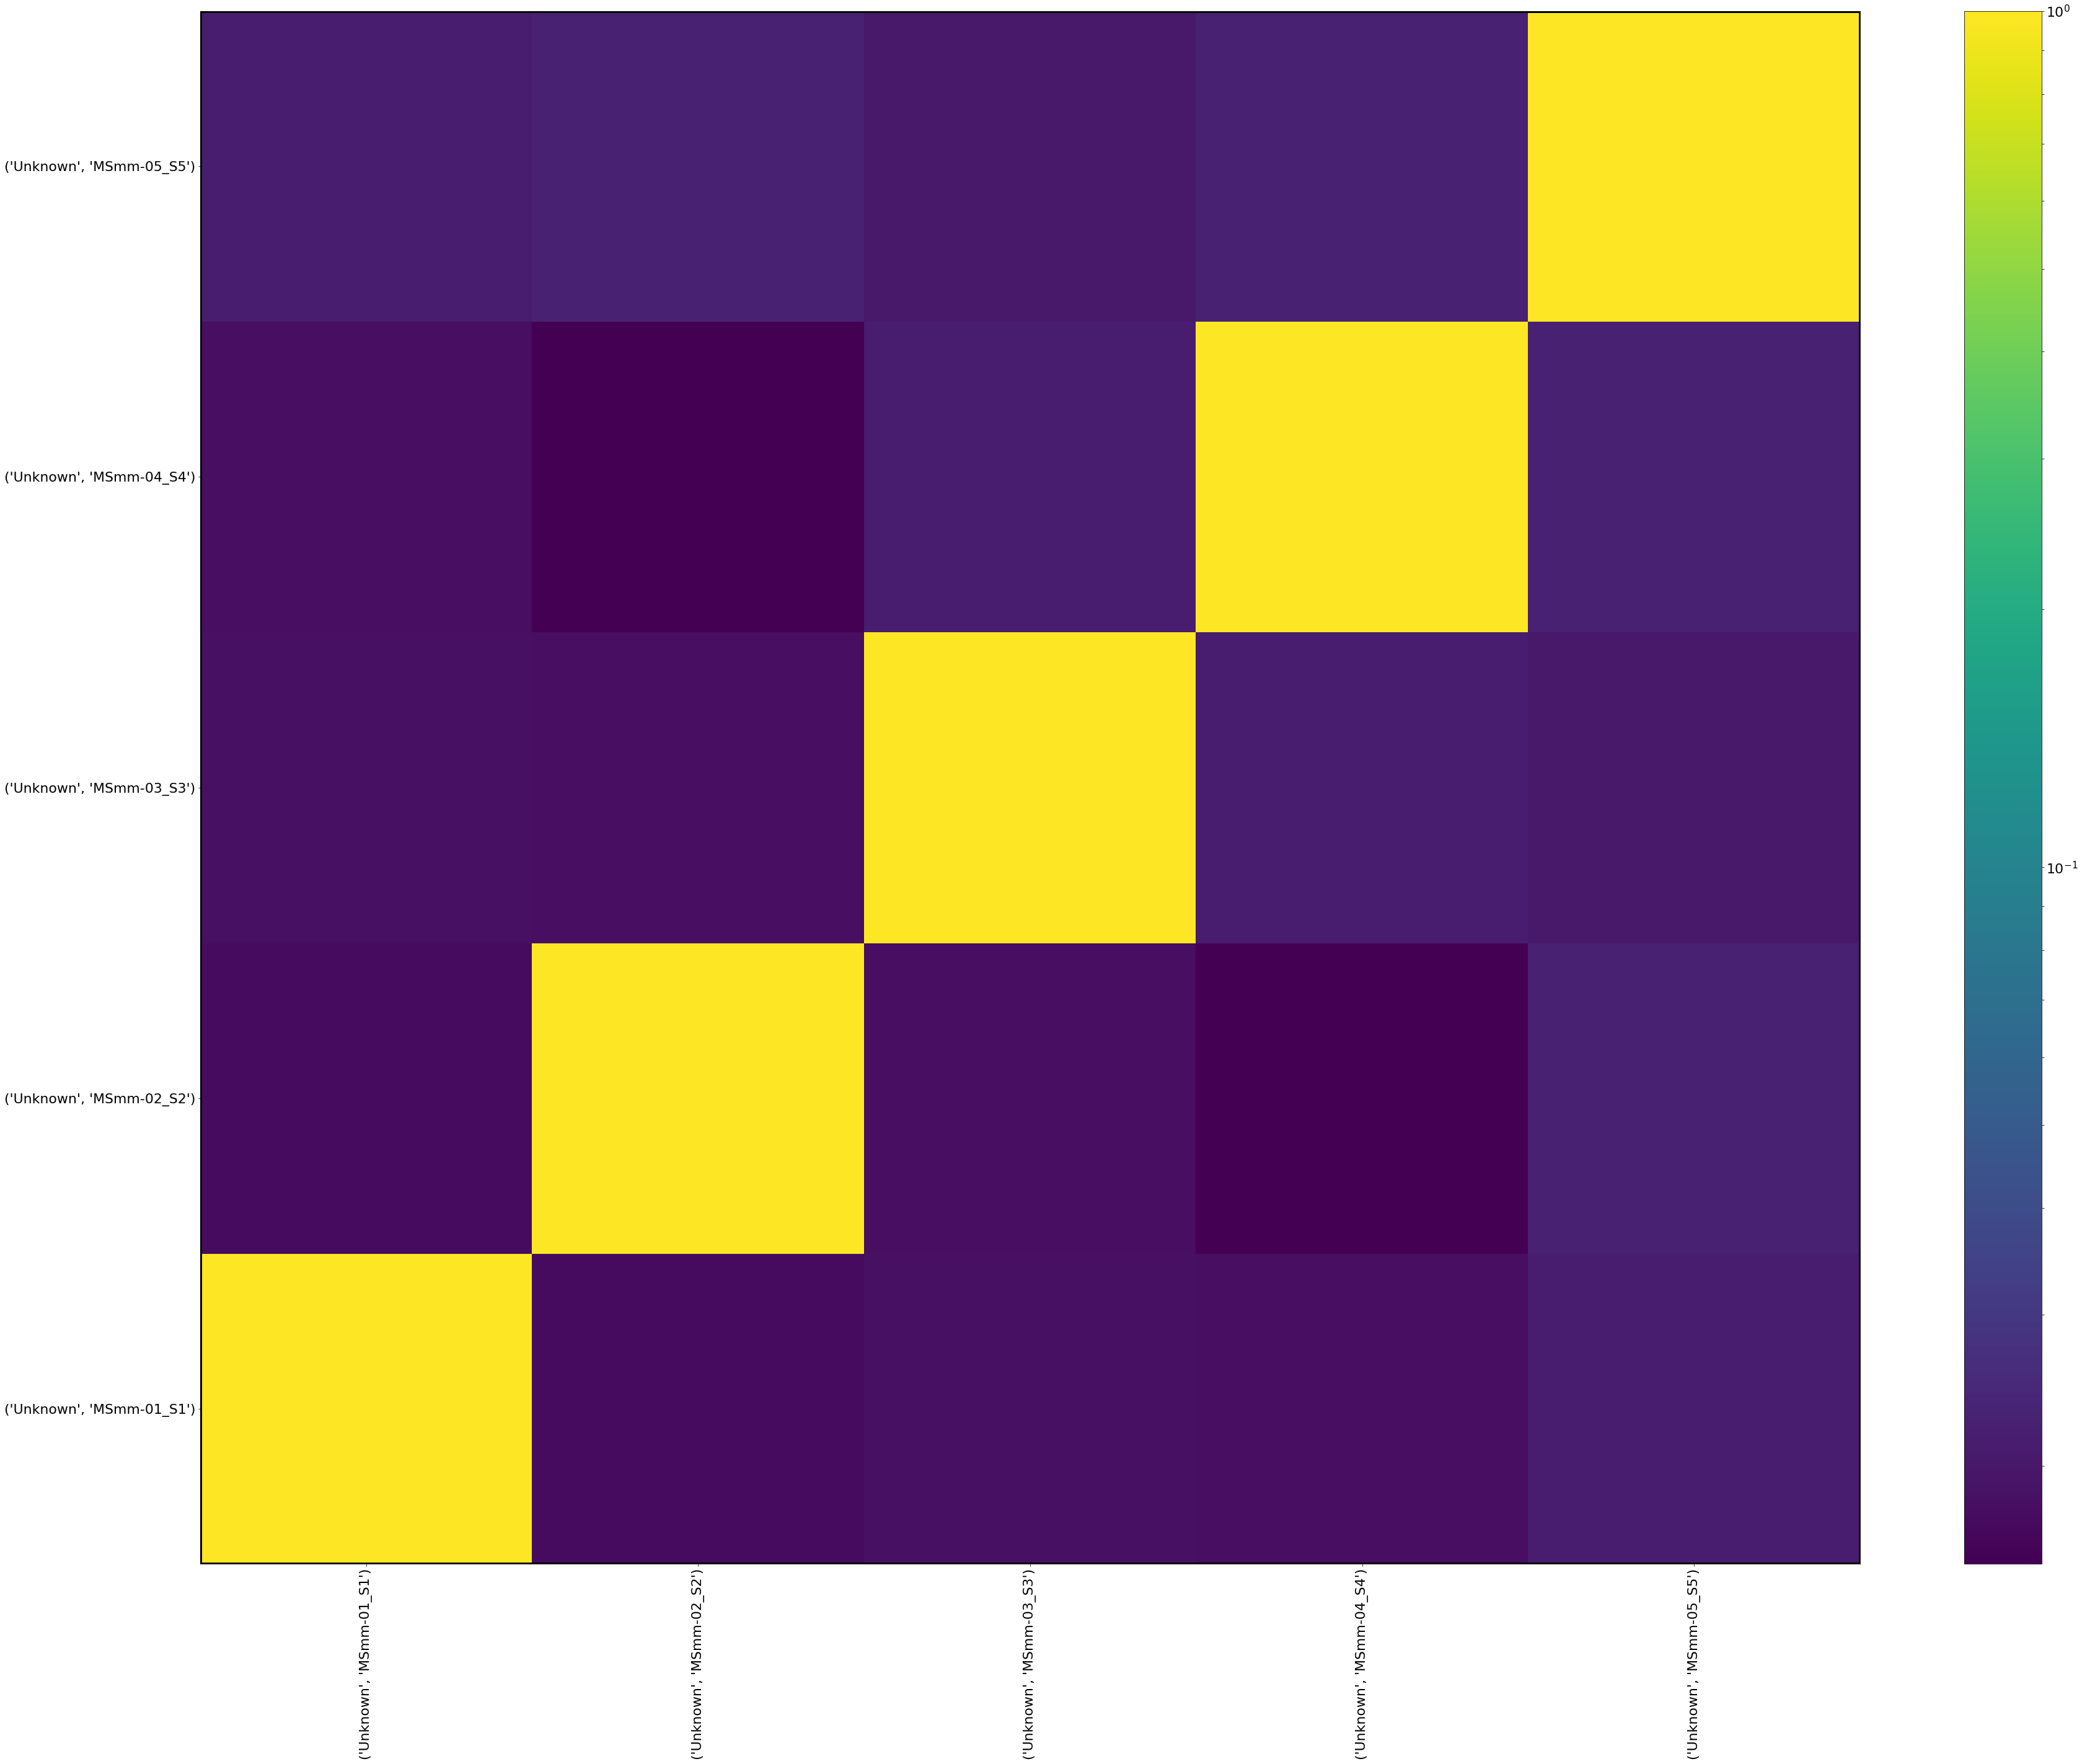

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)